In [1]:
# import basic packages
import pandas as pd
import seaborn as sns
import numpy as np
import os
import yaml
import joblib
import matplotlib.pyplot as plt

# import sklearn model dev packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import BAGS and bias metrics
from util import calculate_disparate_impact, calculate_statistical_parity_difference
from bias_aware_gridsearch import BiasAwareGridSearchCV

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

### Prediction Task: Will an applicant be approved for a home purchase conventional mortgage?

### Data Processing

In [2]:
# read in all mortgage data from 2017
mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')

/var/folders/gp/89jvsfhd6zn10r7krkzw4l7w0000gn/T/ipykernel_78957/2354709147.py:2: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')


In [3]:
# dropping columns with only invalid values
mort_df = mort_df.dropna(axis = 1, how = 'all')

In [4]:
mort_df.shape

(14285496, 74)

In [5]:
mort_df.describe()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,...,denial_reason_3,rate_spread,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
count,14285496.0,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428046e+07,1.428550e+07,1.428550e+07,1.249445e+07,...,49338.000000,493273.000000,1.428550e+07,1.428550e+07,1.400119e+07,1.400114e+07,1.400119e+07,1.400119e+07,1.400114e+07,1.400114e+07
mean,2017.0,6.809450e+00,1.439923e+00,1.044156e+00,1.845050e+00,1.102287e+00,2.480836e+02,2.796495e+00,2.627451e+00,3.045841e+04,...,5.053833,2.473063,1.999748e+00,1.522989e+00,5.720964e+03,3.273188e+01,7.083347e+04,1.130236e+02,1.465340e+03,2.004188e+03
std,0.0,2.122487e+00,7.467081e-01,2.224088e-01,9.484542e-01,3.172205e-01,1.481113e+03,4.790466e-01,1.931120e+00,1.132808e+04,...,2.680472,1.441981,1.587924e-02,1.087268e+00,3.170171e+03,2.618514e+01,1.494926e+04,4.088793e+01,8.862358e+02,1.099152e+03
min,2017.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,...,1.000000,1.500000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.580000e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.120000e+02,3.000000e+00,1.000000e+00,1.966000e+04,...,3.000000,1.660000,2.000000e+00,1.000000e+00,3.853000e+03,1.173000e+01,6.160000e+04,8.649000e+01,9.260000e+02,1.341000e+03
50%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.850000e+02,3.000000e+00,1.000000e+00,3.278000e+04,...,5.000000,1.900000,2.000000e+00,1.000000e+00,5.161000e+03,2.485000e+01,6.810000e+04,1.077000e+02,1.321000e+03,1.817000e+03
75%,2017.0,9.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,2.900000e+02,3.000000e+00,4.000000e+00,4.014000e+04,...,7.000000,2.490000,2.000000e+00,1.000000e+00,6.784000e+03,4.782000e+01,7.750000e+04,1.331300e+02,1.808000e+03,2.422000e+03
max,2017.0,9.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.400000e+06,3.000000e+00,8.000000e+00,4.978000e+04,...,9.000000,99.990000,2.000000e+00,4.000000e+00,5.381200e+04,1.000000e+02,1.315000e+05,5.074700e+02,1.952900e+04,2.539100e+04


In [6]:
# Removing instances of incomplete/withdrawn and preapproval only applications
inval_obs = [i for i, j in mort_df['action_taken'].items() if j in [1, 3]]
prim_df = mort_df.iloc[inval_obs]

# Limit to only conventional loans for home purchases in California
prim_df = prim_df[(prim_df['loan_purpose'] == 1) & 
                  (prim_df['loan_type'] == 1) & 
                  (prim_df['state_abbr'] == 'CA')]

# Limit demographic data scope to only primary applicants; dropping unnecessary columns
prim_df = prim_df[['action_taken_name', 'action_taken', 'state_name', 
                   'state_abbr', 'applicant_ethnicity_name', 'applicant_ethnicity', 
                   'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2', 
                   'applicant_race_2', 'applicant_sex_name', 'applicant_sex', 
                   'applicant_income_000s']]

In [7]:
# Filling invalid values
prim_df = prim_df.reset_index(drop= True)

prim_df = prim_df.replace('Information not provided by applicant in mail, Internet, or telephone application', 
                          'Not applicable')
prim_df = prim_df.fillna(0)

In [8]:
prim_df.shape

(331391, 13)

In [9]:
prim_df = prim_df.replace([True, False], [1, 0])

### EDA

Text(0.5, 1.0, 'Counts of Actions Taken')

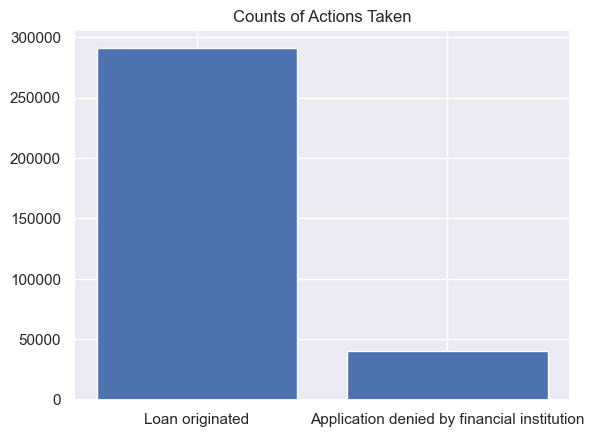

In [10]:
# Action Taken
actions = prim_df['action_taken_name'].value_counts()

plt.bar(actions.index, actions)
plt.title('Counts of Actions Taken')

The chart above depicts the counts of the result of each application, either denial or loan origination. As is shown, this dataset is unbalanced. The negative class, application denial, makes up only 12% of the distribution. For the purposes of this analysis, no further preprocessing will be done to adress this. This will be revisted should the project call for it. 

Text(0.5, 1.0, 'Gender')

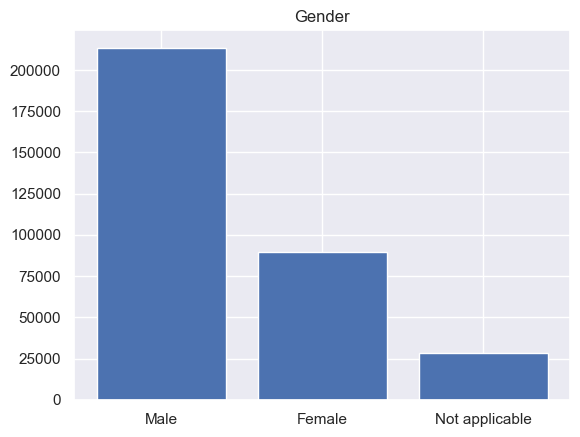

In [11]:
# Sex
gender = prim_df['applicant_sex_name'].value_counts()

plt.bar(gender.index, gender)
plt.title('Gender')

The above chart shows that males make up a majority of primary applicants (~64%). For this project, sex will be analyzed as the protected attribute. The later models will outline whether or not there is bias between sex when it comes to loan origination.

In [12]:
prim_df['applicant_race_name_1'].unique()

array(['Asian', 'Not applicable', 'White', 'Black or African American',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

Text(0.5, 1.0, 'Race')

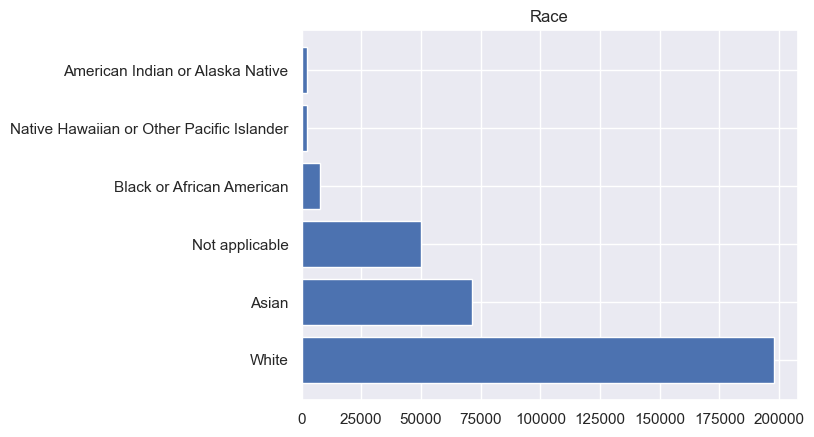

In [13]:
# Race
race = prim_df['applicant_race_name_1'].value_counts()

plt.barh(race.index, race)
plt.title('Race')

Of the race of the primary applicants, White is the most common, making up about 60% of the dataset. It is to be noted that many under this racial group identify as hispanic/latino, which could potentially play a factor in the bias results. The next largest racial group is Asian, which makes up about 21% of the distribution.

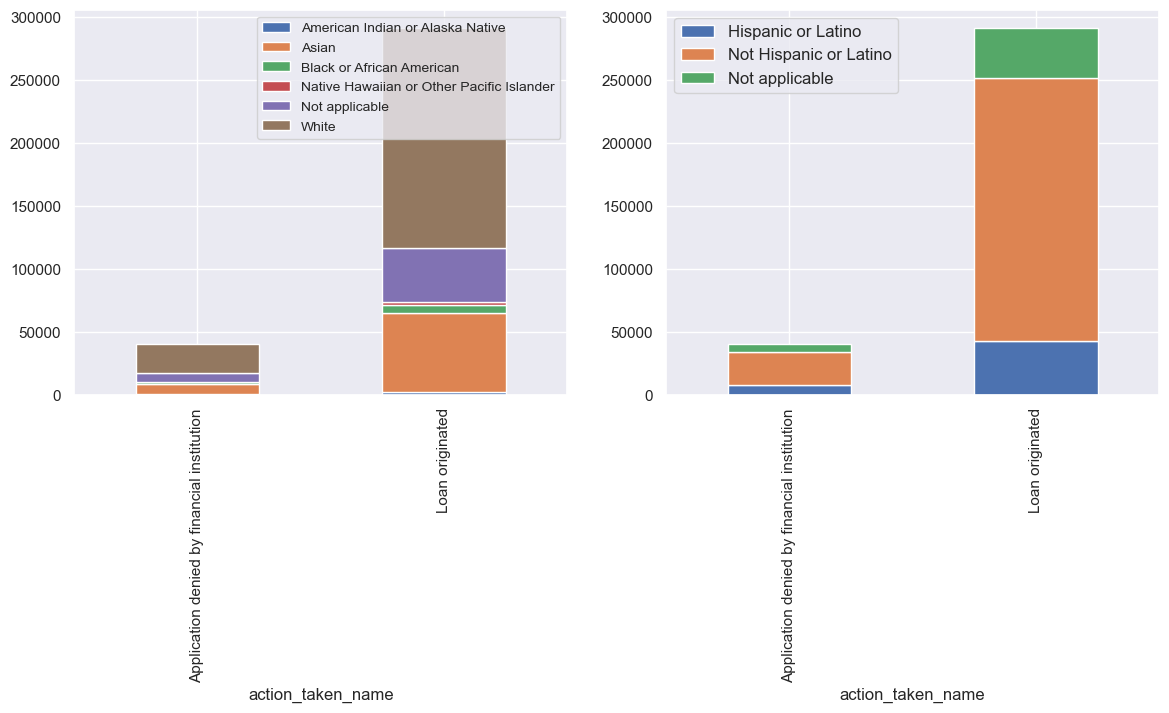

In [14]:
action_by_race = prim_df.groupby(['action_taken_name', 'applicant_race_name_1'])['action_taken'].count()
action_by_eth = prim_df.groupby(['action_taken_name', 'applicant_ethnicity_name'])['action_taken'].count()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

action_by_race.unstack().plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(fontsize = 'small')

action_by_eth.unstack().plot(kind='bar', stacked=True, ax=ax2)
ax2.legend(fontsize = 'medium')

The charts above show the racial and ethnic distributions of the actions taken, denial or loan origination. White, non- Hispanic or Latino applicants are the majority class in this dataset, making up about 45% of the dataset.

In [15]:
race_props = (action_by_race / actions).unstack()
eth_props = (action_by_eth / actions).unstack()

In [16]:
race_props

applicant_race_name_1,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,Not applicable,White
action_taken_name,,,,,,
Application denied by financial institution,0.009021,0.198410,0.035288,0.008971,0.176292,0.572018
Loan originated,0.005897,0.217021,0.022129,0.006674,0.147913,0.600365


This table depicts the specific distribution of the actions taken. Overall, the distribution is similar with the largest differences in the proportion of White (57% vs 60%) and Asian (19% vs 21%) people. This suggests that those racial groups are slightly less likely to be denied a mortgage.

In [17]:
eth_props

applicant_ethnicity_name,Hispanic or Latino,Not Hispanic or Latino,Not applicable
action_taken_name,,,
Application denied by financial institution,0.195601,0.652833,0.151566
Loan originated,0.147508,0.714732,0.137760


This table shows the distributions of ethnic groups. Those who identify as not Hispanic or Latino are overall more likely to have their loan originated (65% vs 71%), the opposite being true for those who idenify as being Hispanic or Latino (19% vs 14%).

### Bias Metrics

In [18]:
X = prim_df.drop(['action_taken_name', 'action_taken', 'applicant_ethnicity_name',
                  'applicant_race_name_2', 'applicant_race_name_1', 'applicant_sex_name', 'state_name', 
                  'state_abbr'], axis = 1)
y = pd.Series([1 if x != 3 else 0 for x in prim_df['action_taken']], name = 'was_approved')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [20]:
train_df = pd.concat([X_train,y_train], axis=1)

In [21]:
calculate_disparate_impact(train_df, 'was_approved', 'applicant_sex', 1, 2, 1)

0.01397431475068811

### Naive GridSearchCV

In [29]:
from os.path import dirname, abspath
script_path = abspath(dirname('params.yaml'))
params_path = os.path.join(script_path, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)

In [30]:
param_grid = param_grid_file['detailed_rfc_params']
param_grid

{'n_estimators': [50, 100, 200, 300, 400, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

In [31]:
estimator = RandomForestClassifier()
gridsearch = GridSearchCV(estimator, param_grid, n_jobs = -2)

In [32]:
from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-2):
#    gridsearch.fit(X_train, y_train)

# joblib.dump(gridsearch, 'naive_grid_search_results.pkl')

In [33]:
naive_gridsearch = joblib.load('naive_grid_search_results.pkl')

#### Calculating disparate impact and accuracy of the best selected model

In [34]:
naive_gs_di = X_test.copy()
naive_gs_di['preds'] = naive_gridsearch.predict(naive_gs_di)
calculate_disparate_impact(naive_gs_di, 'preds', 'applicant_sex', 1, 2, 1)

0.16025118154760043

In [35]:
y_preds = naive_gridsearch.predict(X_test) 
gs_test = (y_preds == y_test).mean()
print('Test Accuracy for best gridsearchCV model: ' + str(gs_test))

Test Accuracy for best gridsearchCV model: 0.6971589794655925


As demonstrated, the model exacerbates the bias very minimally preset in the data. The disparate impact increases from ~0.01397 to ~0.1603, indicating that the best model found from the naive gridsearch introduced bias into its predictions. Our goal is to find the best parameters to minimize the introduction of bias while also not compromising the accuracy of the model itself, so let's try doing a bias aware grid search using the same parameters.

### Bias Aware GridSearchCV

In [36]:
estimator = RandomForestClassifier()

ba_grid_search = BiasAwareGridSearchCV(estimator, param_grid, train_df, 'was_approved', 'applicant_sex', 1, 2, 1, n_jobs = -1)
ba_grid_search.fit(X_train, y_train, calculate_disparate_impact)

Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Pro

PicklingError: Could not pickle the task to send it to the workers.

In [75]:
# joblib.dump(grid_search_ss, 'grid_search_3_results.pkl')
# loaded_bags_model = joblib.load('grid_search_3_results.pkl')

['grid_search_3_results.pkl']

There are three different options to choose from regarding model selection criteria, which can be chosen based on use case. First is the model with the highest accuracy, which is the method used in a naive GridSearchCV.

In [28]:
# Model with the highest accuracy (naive gridsearch selection)
bags_bestacc = loaded_bags_model.select_highest_accuracy_model()

Selected model parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 40, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100} with accuracy: 0.6960567833275298, bias: 0.1508566650405191


In [ ]:
test_df = X_test.copy()
test_df['y_pred'] = bags_bestacc.predict(test_df)
print("Test accuracy of most accurate model: " + str((test_df['y_pred'] == y_test).mean()))
print("Disparate Impact of most accurate model: " + str(calculate_disparate_impact(test_df, 'y_pred', 
                                                                              'applicant_sex', 1, 2, 1)))

Next, we will take a look at the model with the least bias.

In [27]:
# Model with the least bias
bags_leastb = loaded_bags_model.select_least_biased_model()

Selected model parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 50} with accuracy: 0.6640136480806059, bias: 0.11898082939065262


In [ ]:
test_df = X_test.copy()
test_df['y_pred'] = bags_leastb.predict(test_df)
print("Test accuracy of least biased model: " + str((test_df['y_pred'] == y_test).mean()))
print("Disparate Impact of least biased model: " + str(calculate_disparate_impact(test_df, 'y_pred', 
                                                                              'applicant_sex', 1, 2, 1)))

Lastly, there is an option to select the most balanced model, which is evaluated using both accuracy and bias in equal measures.

In [26]:
# Model with the best balance between accuracy and bias
bags_bal = loaded_bags_model.select_balanced_model(10)

Selected model parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} with accuracy: 0.6944687440527766, bias: 0.14994845252980935


In [ ]:
test_df = X_test.copy()
test_df['y_pred'] = bags_bal.predict(test_df)
print("Test accuracy of balanced model: " + str((test_df['y_pred'] == y_test).mean()))
print("Disparate Impact of balanced model: " + str(calculate_disparate_impact(test_df, 'y_pred', 
                                                                              'applicant_sex', 1, 2, 1)))

#### Plots

Our package features visualization tools that give a glimpse into how each parameter behaved in relation to bias. 

/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


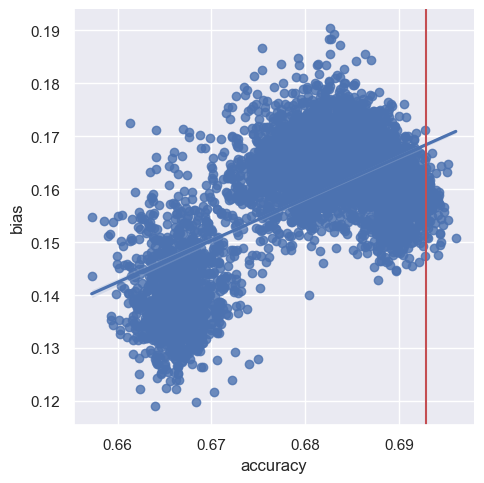

In [61]:
loaded_bags_model.plot_accuracy(100)

This plot demonstrates the relationship between accuracy and bias amongst the many parameter combinations. In this specific dataset, it seems that as accuracy increases, bias also slightly increases. 

/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/stephaniechavez/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


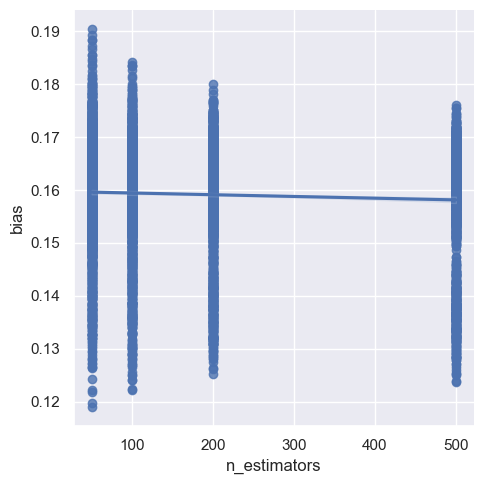

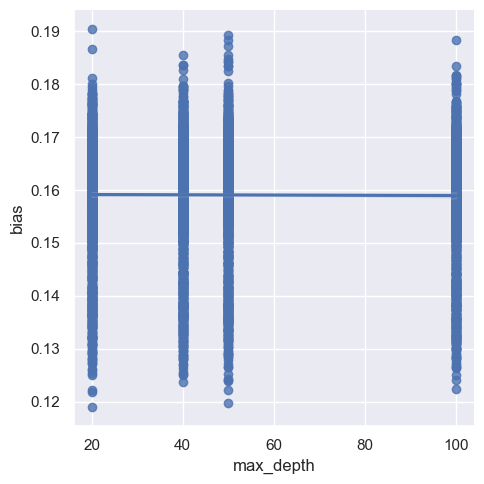

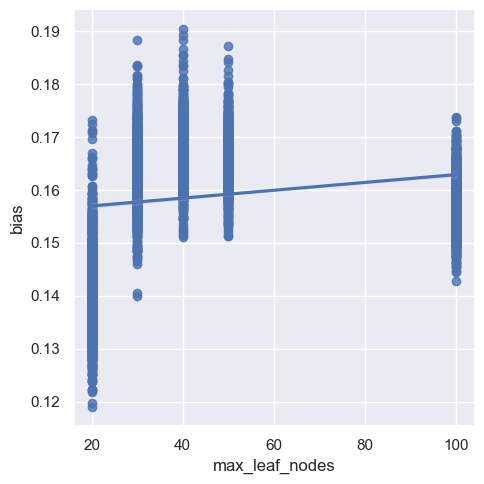

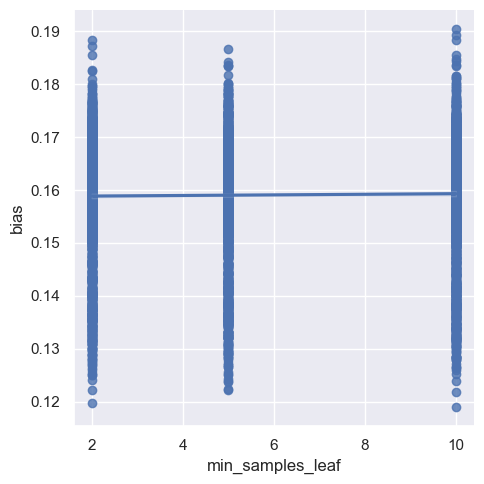

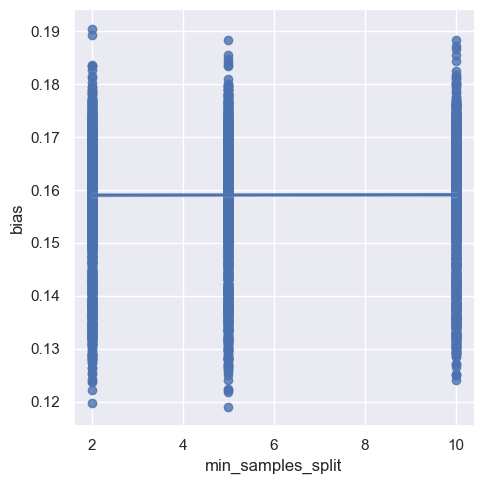

In [58]:
continuous_params = ['n_estimators', 'max_depth', 'max_leaf_nodes', 'min_samples_leaf', 'min_samples_split']
for param in continuous_params:
    loaded_bags_model.plot_params(param)

The plots above highlight the relationships between each continuous parameter and bias. The parameter of note in this example is max_leaf_nodes. Bias tends to increase as the number of max_leaf_nodes increase.

### Conclusions